In the below I present basic convolutional autoencoder and its ability to reconstructing imagees using the well know dataset mnist. 

The model is written using tf.keras and assigned to appropriate class, as shown below. The class data helps with preparing original sets into the form the model requires and allows to split the training set into the training and validation ones. The autoencoder model contains 6 convoluational layers, three together with max poolings make the encoder part, another three together with up sampling layers make the decoder one. The activation function used in all convolutional layers it the rectified linear unit (ReLU), except the output layer that uses the sigmoid one. Chosen otpimizer is the adaptive momentum estimation (Adam) with default learning rate (0.001), it seemed to be the best one for the recounstruction task, below there are shown results with other optimizers. The loss function is chosen to be the binary_crossentropy, another tested gave much less accuracy and caused the model completely unable to recounstruct anything.

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
class data:
    def __init__(self, input, name):
        self.name = name ### name
        self.normalized = input.astype("float32") / 255.  ### normalizing
        self.final = self.normalized.reshape(-1, 28, 28, 1) ### reshaping

    def train_val_split(self, val_size):
        if val_size > 1 or val_size <= 0:
            raise SyntaxError("Validation size should be a float between 0 and 1")
        perm = list(np.random.permutation(self.final.shape[0]))
        split_index = int(self.final.shape[0] * val_size)
        train_idxs = perm[:split_index]
        test_idxs = perm[split_index:]
        self.train = self.final[train_idxs] ### train set
        self.val = self.final[test_idxs] ### validation set

class encoder: ### encoder_model
    def __init__(self, input):
        self.input = tf.keras.Input(shape=[28, 28, 1], dtype=tf.float32, name='encoder_input')
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1')(self.input)
        self.max1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='max1')(self.conv1)
        self.conv2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(self.max1)
        self.max2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='max2')(self.conv2)
        self.conv3 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='conv3')(self.max2)
        self.max3 = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='max3')(self.conv3)

class decoder: ### decoder_model
    def __init__(self, input):
        self.input = tf.keras.Input(shape=[4, 4, 8], dtype=tf.float32, name='decoder_input')
        self.conv4 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='conv4')(self.input)
        self.up4 = tf.keras.layers.UpSampling2D((2, 2), name='up4')(self.conv4)
        self.conv5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv5')(self.up4)
        self.up5 = tf.keras.layers.UpSampling2D((2, 2), name='up5')(self.conv5)
        self.conv6 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='valid', name='conv6')(self.up5)
        self.up6 = tf.keras.layers.UpSampling2D((2, 2), name='up6')(self.conv6)
        self.outputs = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid', name='output')(self.up6)

Once the model is written we download the data (without labels). Once splitted, model can be created. The autoencoder is merged from the previous two, encoder and decoder are created in classical way. 
In general, that could be simplify by making one autoencoder model, instead of creating encoder and decoder separately, and merging them. Nevertheless, I think it's much more clear how both parts work, once looking on them particularly, and secondly, this approach seems to be more genearal once one would like to upgrade this code to variational autoencoder. Anyway, summaries for all three are presented below.

In [3]:
(x_train, _ ), (x_test, _ ) = mnist.load_data() ### download the data without labels

In [4]:
input = data(x_train, "mnist")
input.train_val_split(0.2)
print("Training set:", input.train.shape, "\nValidation set:", input.val.shape)

Training set: (12000, 28, 28, 1) 
Validation set: (48000, 28, 28, 1)


In [48]:
tf.keras.backend.clear_session()

In [49]:
encod = encoder(input.train) 
decod = decoder(encod.max3)

encoder_model = tf.keras.Model(encod.input, encod.max3, name='Encoder')
decoder_model = tf.keras.Model(decod.input, decod.outputs, name='Decoder')

autoencoder = tf.keras.Model(encod.input, decoder_model(encoder_model(encod.input)), name="Autoencoder")

In [50]:
encoder_model.summary()
print()
decoder_model.summary()
print()
autoencoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 16)        160       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 16)        2320      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 8)           1160      
_________________________________________________________________
max3 (MaxPooling2D)          (None, 4, 4, 8)           0   

In [51]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])

Once training the model on my end, I have been noticing that the model raises its accuracy very, very slow. The accuracy around 20-30 epoch was usually eqaul to +/- 0.806, once around 70-80 epoch, the accuracy grew to 0.81, so in the below the early stopping callback is used to avoid going thruogh all set epochs.

In [53]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, restore_best_weights=False)

In [54]:
history = autoencoder.fit(x=input.train, y=input.train, epochs=100, shuffle=True, batch_size=256, validation_data=(input.val, input.val), callbacks=[es])

Train on 12000 samples, validate on 48000 samples
Epoch 1/100
12000/12000 [==============================] - 6s 516us/sample - loss: 0.4454 - acc: 0.8047 - val_loss: 0.2724 - val_acc: 0.8087
Epoch 2/100
12000/12000 [==============================] - 4s 374us/sample - loss: 0.2310 - acc: 0.8092 - val_loss: 0.2139 - val_acc: 0.8078
Epoch 3/100
12000/12000 [==============================] - 4s 373us/sample - loss: 0.1991 - acc: 0.7953 - val_loss: 0.1878 - val_acc: 0.7883
Epoch 4/100
12000/12000 [==============================] - 4s 373us/sample - loss: 0.1790 - acc: 0.7921 - val_loss: 0.1727 - val_acc: 0.7913
Epoch 5/100
12000/12000 [==============================] - 4s 375us/sample - loss: 0.1652 - acc: 0.7965 - val_loss: 0.1607 - val_acc: 0.7992
Epoch 6/100
12000/12000 [==============================] - 4s 374us/sample - loss: 0.1548 - acc: 0.7999 - val_loss: 0.1516 - val_acc: 0.7996
Epoch 7/100
12000/12000 [==============================] - 4s 373us/sample - loss: 0.1473 - acc: 0.8021 

Once the model is trained we are ready to predict test images and look how it reconstructs them.

In [55]:
test = data(x_test, "x_test")
pred_imgs = autoencoder.predict(test.final)

In [56]:
def reals_and_predictions(n):
    len = test.final.shape[0]
    perm = np.random.permutation(len)
    perm = perm[:n]

    ax_s = []
    for i in range(n):
        ax_s.append(str("ax") + str(i))

    f, ax_s = plt.subplots(1, n, figsize=(20,2))
    f.suptitle("Test Images", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(test.final[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')

    g, ax_s = plt.subplots(1, n, figsize=(20,2))
    g.suptitle("Reconstructed Images", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(pred_imgs[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

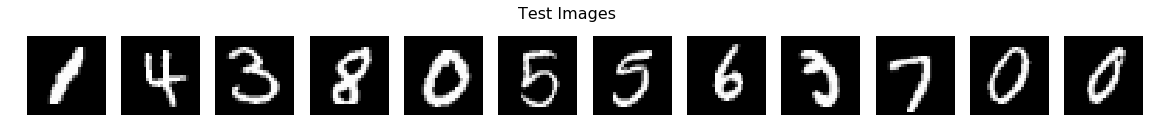

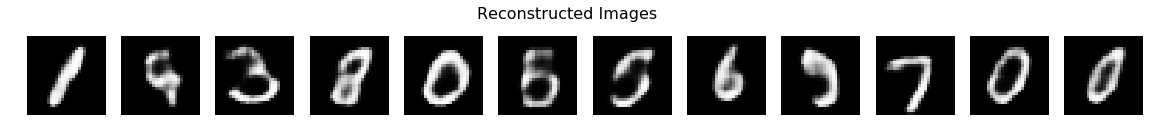

In [63]:
reals_and_predictions(12)

As we can see, most of digits can be recognized as reconstructed properly, there are some exceptions though: 8's and 3's are sometimes undistinguishable after recounstruction, 6's and 5' also has this tendency, but not so often. As mentioned at the beggining we can also take a look on recounstructions by different optimizers. For each one we train through 3 epochs only, it has no impact on the result anyway.

In [72]:
tf.keras.backend.clear_session()
encod = encoder(input.train) 
decod = decoder(encod.max3)
encoder_model = tf.keras.Model(encod.input, encod.max3, name='Encoder')
decoder_model = tf.keras.Model(decod.input, decod.outputs, name='Decoder')
autoencoder = tf.keras.Model(encod.input, decoder_model(encoder_model(encod.input)), name="Autoencoder")
autoencoder.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['acc'])
autoencoder.fit(x=input.train, y=input.train, epochs=3, shuffle=True, batch_size=256, validation_data=(input.val, input.val))

Train on 12000 samples, validate on 48000 samples
Epoch 1/3
12000/12000 [==============================] - 6s 481us/sample - loss: 0.3383 - acc: 0.7903 - val_loss: 0.2329 - val_acc: 0.7889
Epoch 2/3
12000/12000 [==============================] - 4s 373us/sample - loss: 0.2228 - acc: 0.7805 - val_loss: 0.2139 - val_acc: 0.7701
Epoch 3/3
12000/12000 [==============================] - 4s 374us/sample - loss: 0.2030 - acc: 0.7847 - val_loss: 0.1951 - val_acc: 0.7938


In [73]:
rmsprop_imgs = autoencoder.predict(test.final)

def rmsprop_predictions(n):
    len = test.final.shape[0]
    perm = np.random.permutation(len)
    perm = perm[:n]

    ax_s = []
    for i in range(n):
        ax_s.append(str("ax") + str(i))

    f, ax_s = plt.subplots(1, n, figsize=(20,2))
    f.suptitle("Test Images", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(test.final[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')

    g, ax_s = plt.subplots(1, n, figsize=(20,2))
    g.suptitle("Reconstructed Images (RMSProp)", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(rmsprop_imgs[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

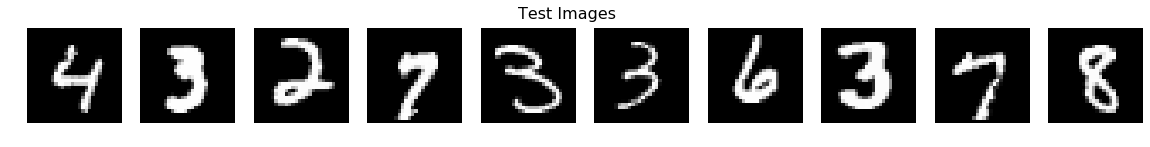

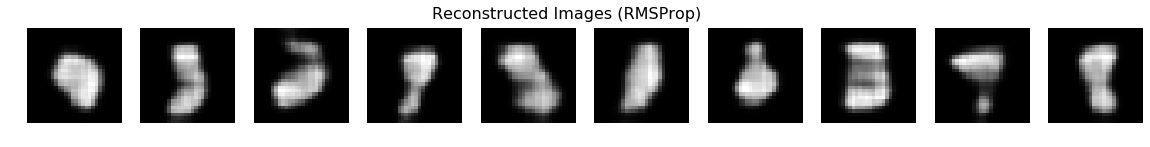

In [79]:
rmsprop_predictions(10)

In [75]:
tf.keras.backend.clear_session()
encod = encoder(input.train) 
decod = decoder(encod.max3)
encoder_model = tf.keras.Model(encod.input, encod.max3, name='Encoder')
decoder_model = tf.keras.Model(decod.input, decod.outputs, name='Decoder')
autoencoder = tf.keras.Model(encod.input, decoder_model(encoder_model(encod.input)), name="Autoencoder")
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
autoencoder.fit(x=input.train, y=input.train, epochs=3, shuffle=True, batch_size=256, validation_data=(input.val, input.val))

Train on 12000 samples, validate on 48000 samples
Epoch 1/3
12000/12000 [==============================] - 5s 458us/sample - loss: 0.6954 - acc: 0.1906 - val_loss: 0.6953 - val_acc: 0.1995
Epoch 2/3
12000/12000 [==============================] - 4s 374us/sample - loss: 0.6952 - acc: 0.2100 - val_loss: 0.6951 - val_acc: 0.2198
Epoch 3/3
12000/12000 [==============================] - 4s 373us/sample - loss: 0.6950 - acc: 0.2310 - val_loss: 0.6949 - val_acc: 0.2417


In [76]:
ada_imgs = autoencoder.predict(test.final)

def ada_predictions(n):
    len = test.final.shape[0]
    perm = np.random.permutation(len)
    perm = perm[:n]

    ax_s = []
    for i in range(n):
        ax_s.append(str("ax") + str(i))

    f, ax_s = plt.subplots(1, n, figsize=(20,2))
    f.suptitle("Test Images", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(test.final[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')

    g, ax_s = plt.subplots(1, n, figsize=(20,2))
    g.suptitle("Reconstructed Images (AdaDelta)", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(ada_imgs[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

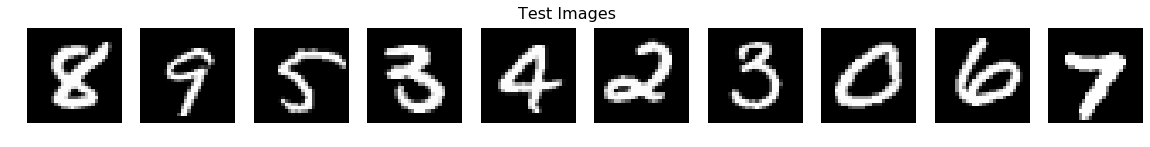

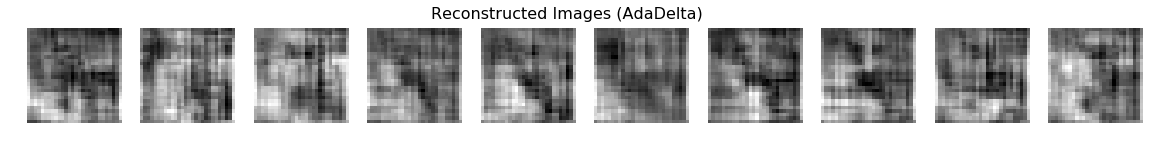

In [77]:
ada_predictions(10)

As the conclusion I would say that with (quite) well chosen hyperparameters, such convolutional autoencoder is able to recounstruct with precision that allows us to recognize these reconstructions. What is interesting, we do not using labels here, so the way of 'predicting' is quite different like in usual neural network/models. The net knows only how to recognize and recounstruct trained patterns, but it does not know that it recognizes ten particular digits and do not assing any test sample into the its class. More advanced autoencoders are able to generate its own samples by providing random weights tensors as the input for the decoder (trained earlier during autoencoder's training). The above definitely cannot be used for such task, anyway, I hope it's helpful somehow, thanks!